In [7]:
# %%
import os
import sys
sys.path.append('/home/sfonseka/dev/SRST/srst-dataloader/models')  # Adds the parent directory to the system path
sys.path.append('/home/sfonseka/dev/SRST/srst-dataloader/utils')  # Adds the parent directory to the system path

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os, cv2
import numpy as np
from PIL import Image
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from torchmetrics.classification import BinaryJaccardIndex as IoU, BinaryAccuracy

import dataloader as dl

In [8]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn  # Make sure this import statement is included


In [9]:
THRESHOLD = 0.5

MODELS_LIST = [
    {
        'CLASS_NAME': 'asphalt',
        'BEST_MODEL': '/home/sfonseka/dev/SRST/srst-dataloader/experiments/UNET/mosaic/runs/UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911/models/best_iou_model_UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911.pt',
        'IOU_MODEL': '/home/sfonseka/dev/SRST/srst-dataloader/experiments/UNET/mosaic/runs/UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911/models/best_mask_iou_model_UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911.pt'
    }
]

import csv

test_results = []

activations = {}

def register_hooks(module):
    if isinstance(module, nn.Conv2d):
        def hook(module, input, output):
            activations[module] = output.detach()
        module.register_forward_hook(hook)


In [10]:


def test_model(model, test_loader, device, class_name, model_path):
    model.eval()

    # Open CSV file for writing
    with open('test_metrics.csv', 'w', newline='') as csvfile:
        fieldnames = ['image_filename', 'test_iou', 'test_accuracy', 'class_name', 'model_path']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write header
        writer.writeheader()

        progress_bar = tqdm(test_loader, desc='Testing', leave=False)
        with torch.no_grad():
            for batch_index, (test_images, test_masks, __paths) in enumerate(progress_bar):
                test_images, test_masks = test_images.to(device), test_masks.to(device)

                for i in range(test_images.size(0)):
                    image = test_images[i].unsqueeze(0)
                    mask = test_masks[i].unsqueeze(0)
                    # print file name
                    image_filename = os.path.basename(__paths[i])
                    print(image_filename)

                    # Plot the image and mask
                    img_np = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
                    
                    output = model(image)
                    output_sigmoid = torch.sigmoid(output)

                    # Convert the output to a binary mask
                    test_pred = (output_sigmoid > THRESHOLD).int()  # Adjust THRESHOLD as needed, e.g., 0.5

                    metric_test_iou = IoU().to(device)  # Initialize IoU for binary classification (background, asphalt)
                    metric_test_accuracy = BinaryAccuracy().to(device)  # Initialize accuracy metric for binary classification

                    metric_test_iou.update(test_pred, mask)
                    metric_test_accuracy.update(test_pred, mask)

                    score_test_iou = metric_test_iou.compute()  # Compute final IoU score
                    score_test_accuracy = metric_test_accuracy.compute()  # Compute final accuracy score

                    # Write metrics to CSV file
                    writer.writerow({'image_filename': image_filename, 'test_iou': score_test_iou.item(), 'test_accuracy': score_test_accuracy.item(), 'class_name': class_name, 'model_path': model_path})

                    # Append results to list
                    test_results.append({
                        'image_filename': image_filename, 
                        'test_iou': score_test_iou.item(), 
                        'test_accuracy': score_test_accuracy.item(), 
                        'class_name': class_name, 
                        'model_path': model_path,
                        'output': output,
                        'pred': test_pred,
                        'mask': mask,
                        'image_np': img_np,   
                    })
           


In [11]:
from UNET import UNetBaseline
model = UNetBaseline(out_classes=1)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE: ', DEVICE)

for item in MODELS_LIST:
    CLASS_NAME = 'mozaik'
    BEST_MODEL = item['BEST_MODEL']

    IMG_DIR = '/projects/0/gusr51794/srst_scratch_drive/binary_training/temp/images'
    TEST_DIR = '/projects/0/gusr51794/srst_scratch_drive/binary_training/temp/masks'

    model.apply(register_hooks)

    state_dict = torch.load(BEST_MODEL, map_location=torch.device('cpu'))['model_state_dict']


    # Load the state dict into the model
    model.load_state_dict(state_dict)
    model.eval()  # Set the model to evaluation mode

    test_dataloader = dl.SRST_DataloaderGray(mask_dir=TEST_DIR, image_dir=IMG_DIR, mask_count=1)
    test_dataset = test_dataloader.dataset

    test_model(model, test_dataloader.data_loader, DEVICE, class_name=CLASS_NAME, model_path=BEST_MODEL)


# Save the test results to a pickle file
with open('test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

DEVICE:  cpu
LEN 1


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

c_set5_4_512_2_8.jpg


In [12]:
# Load the results from pickle
import pickle
with open('test_results.pkl', 'rb') as f:
     test_results = pickle.load(f)


In [13]:
# Get all the keys from test_results
keys = test_results
keys

[{'image_filename': 'c_set5_4_512_2_8.jpg',
  'test_iou': 0.04447564855217934,
  'test_accuracy': 0.3744316101074219,
  'class_name': 'mozaik',
  'model_path': '/home/sfonseka/dev/SRST/srst-dataloader/experiments/UNET/mosaic/runs/UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911/models/best_iou_model_UNET_binary_grayscale_mozaik_MASKED_METRICS_1708016451.646911.pt',
  'output': tensor([[[[-1.4268, -1.0523, -1.1891,  ..., -0.3193, -0.3501, -0.8714],
            [-0.9532, -0.6360, -0.8380,  ..., -0.0446, -0.0473, -0.3135],
            [-0.9273, -0.6430, -0.9362,  ..., -0.2327, -0.0860, -0.3031],
            ...,
            [-1.5137, -1.4025, -1.3052,  ..., -0.7896, -0.5506, -0.9854],
            [-1.4919, -1.5011, -1.4025,  ..., -0.5158, -0.3638, -0.9347],
            [-1.7013, -1.5206, -1.5247,  ..., -0.8138, -0.8671, -1.3685]]]]),
  'pred': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
     

c_set5_4_512_2_8.jpg 0.04447564855217934 0.3744316101074219
output tensor([[[[0.1936, 0.2588, 0.2334,  ..., 0.4208, 0.4133, 0.2950],
          [0.2782, 0.3462, 0.3020,  ..., 0.4889, 0.4882, 0.4223],
          [0.2835, 0.3446, 0.2817,  ..., 0.4421, 0.4785, 0.4248],
          ...,
          [0.1804, 0.1974, 0.2133,  ..., 0.3123, 0.3657, 0.2718],
          [0.1836, 0.1823, 0.1974,  ..., 0.3738, 0.4100, 0.2820],
          [0.1543, 0.1794, 0.1788,  ..., 0.3071, 0.2959, 0.2029]]]])
output min tensor(0.0002)
output max tensor(0.8844)


NameError: name 'pred' is not defined

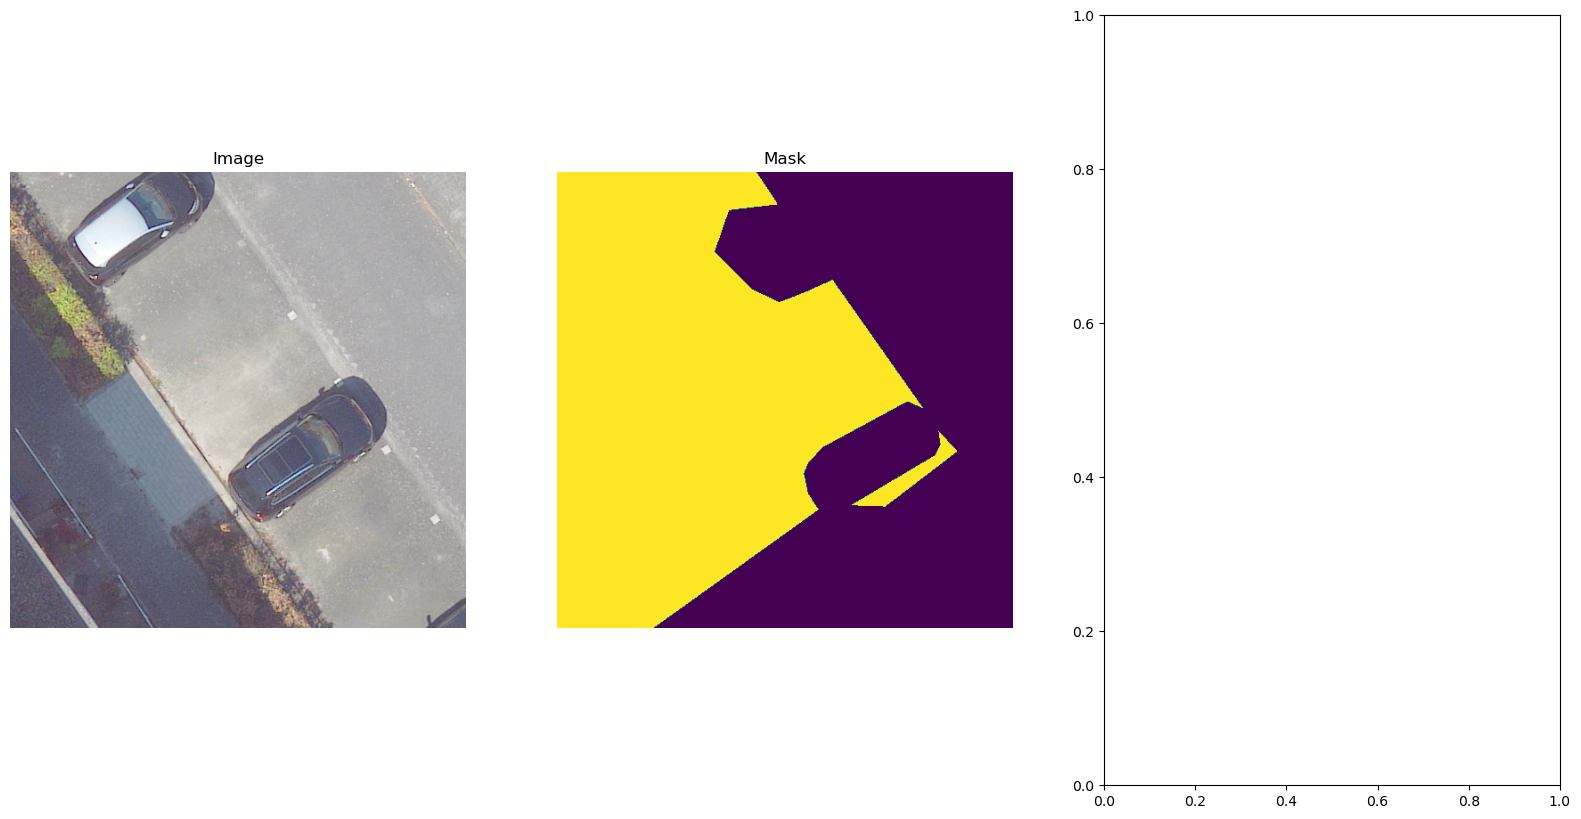

In [14]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    # print(pred)
    print('---' * 10)

    pred = item['pred'].int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = item['pred'].squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set5_4_512_2_8.jpg 0.04447564855217934 0.3744316101074219
output tensor([[[[0.1936, 0.2588, 0.2334,  ..., 0.4208, 0.4133, 0.2950],
          [0.2782, 0.3462, 0.3020,  ..., 0.4889, 0.4882, 0.4223],
          [0.2835, 0.3446, 0.2817,  ..., 0.4421, 0.4785, 0.4248],
          ...,
          [0.1804, 0.1974, 0.2133,  ..., 0.3123, 0.3657, 0.2718],
          [0.1836, 0.1823, 0.1974,  ..., 0.3738, 0.4100, 0.2820],
          [0.1543, 0.1794, 0.1788,  ..., 0.3071, 0.2959, 0.2029]]]])
output min tensor(0.0002)
output max tensor(0.8844)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


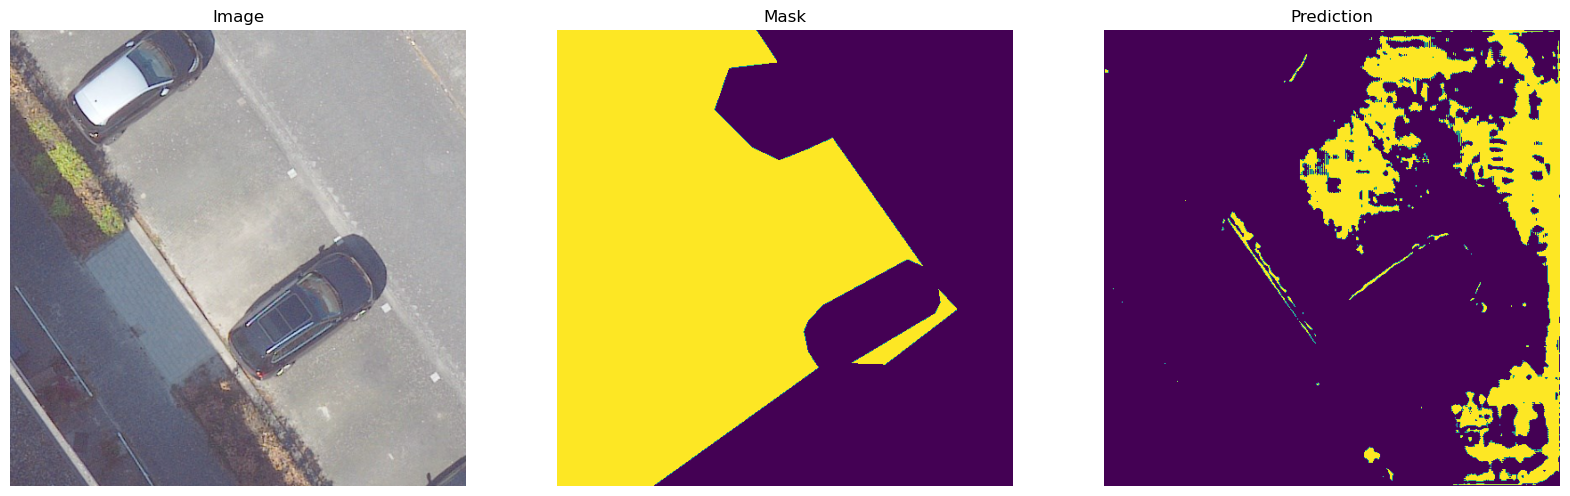

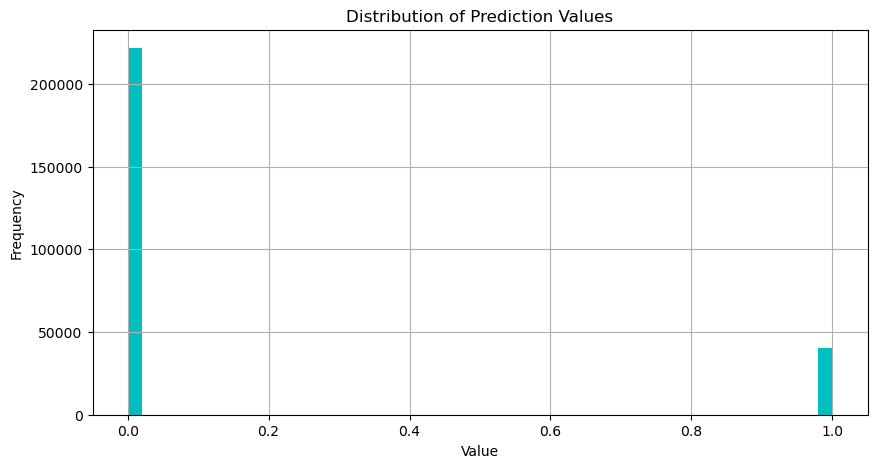

In [92]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = item['pred'].int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = item['pred'].squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set5_4_512_2_8.jpg 0.04447564855217934 0.3744316101074219
output tensor([[[[0.1936, 0.2588, 0.2334,  ..., 0.4208, 0.4133, 0.2950],
          [0.2782, 0.3462, 0.3020,  ..., 0.4889, 0.4882, 0.4223],
          [0.2835, 0.3446, 0.2817,  ..., 0.4421, 0.4785, 0.4248],
          ...,
          [0.1804, 0.1974, 0.2133,  ..., 0.3123, 0.3657, 0.2718],
          [0.1836, 0.1823, 0.1974,  ..., 0.3738, 0.4100, 0.2820],
          [0.1543, 0.1794, 0.1788,  ..., 0.3071, 0.2959, 0.2029]]]])
output min tensor(0.0002)
output max tensor(0.8844)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


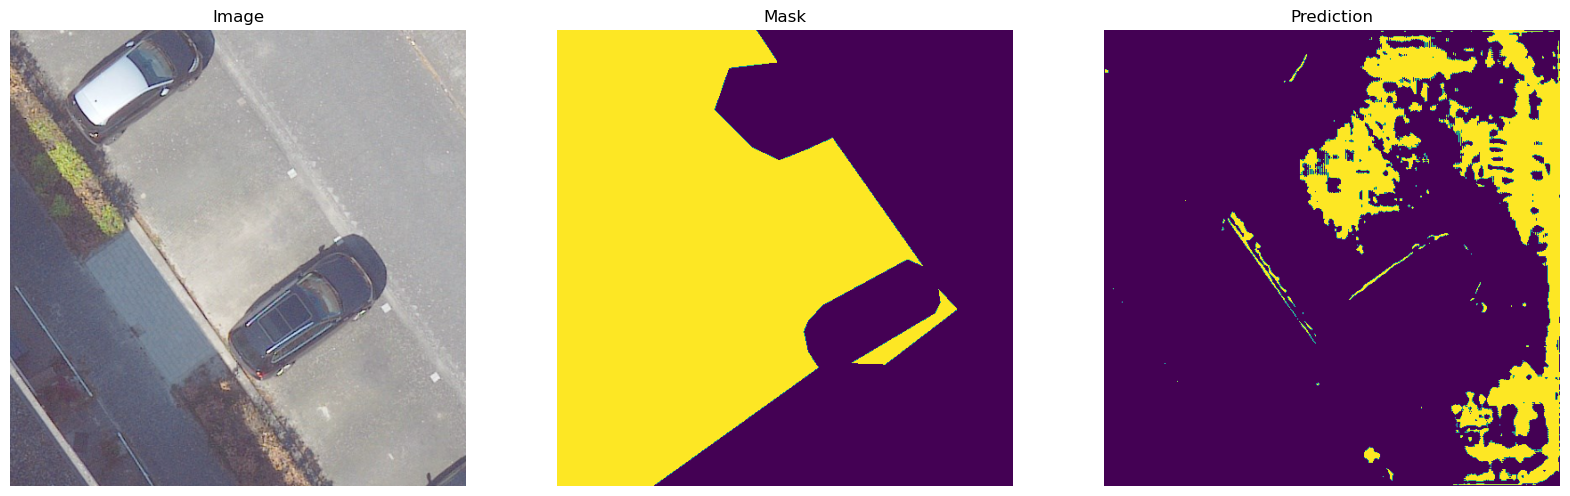

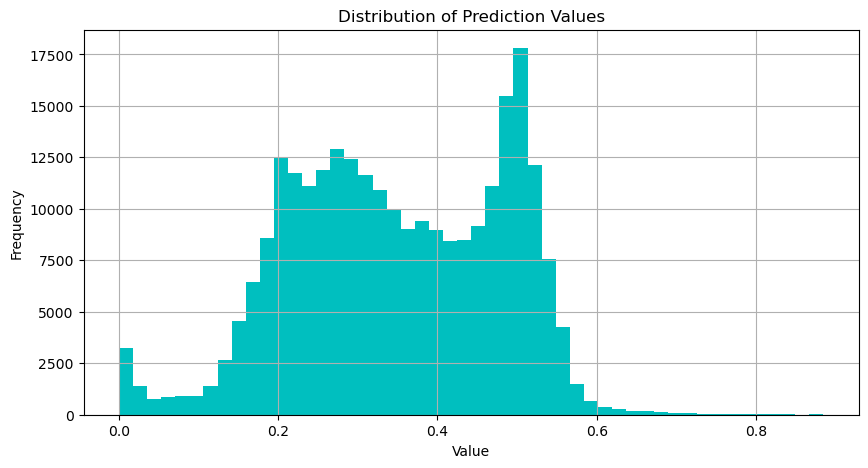

In [83]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = (output_sigmoid > 0.5).int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set5_4_512_2_8.jpg 0.04447564855217934 0.3744316101074219
output tensor([[[[0.1936, 0.2588, 0.2334,  ..., 0.4208, 0.4133, 0.2950],
          [0.2782, 0.3462, 0.3020,  ..., 0.4889, 0.4882, 0.4223],
          [0.2835, 0.3446, 0.2817,  ..., 0.4421, 0.4785, 0.4248],
          ...,
          [0.1804, 0.1974, 0.2133,  ..., 0.3123, 0.3657, 0.2718],
          [0.1836, 0.1823, 0.1974,  ..., 0.3738, 0.4100, 0.2820],
          [0.1543, 0.1794, 0.1788,  ..., 0.3071, 0.2959, 0.2029]]]])
output min tensor(0.0002)
output max tensor(0.8844)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


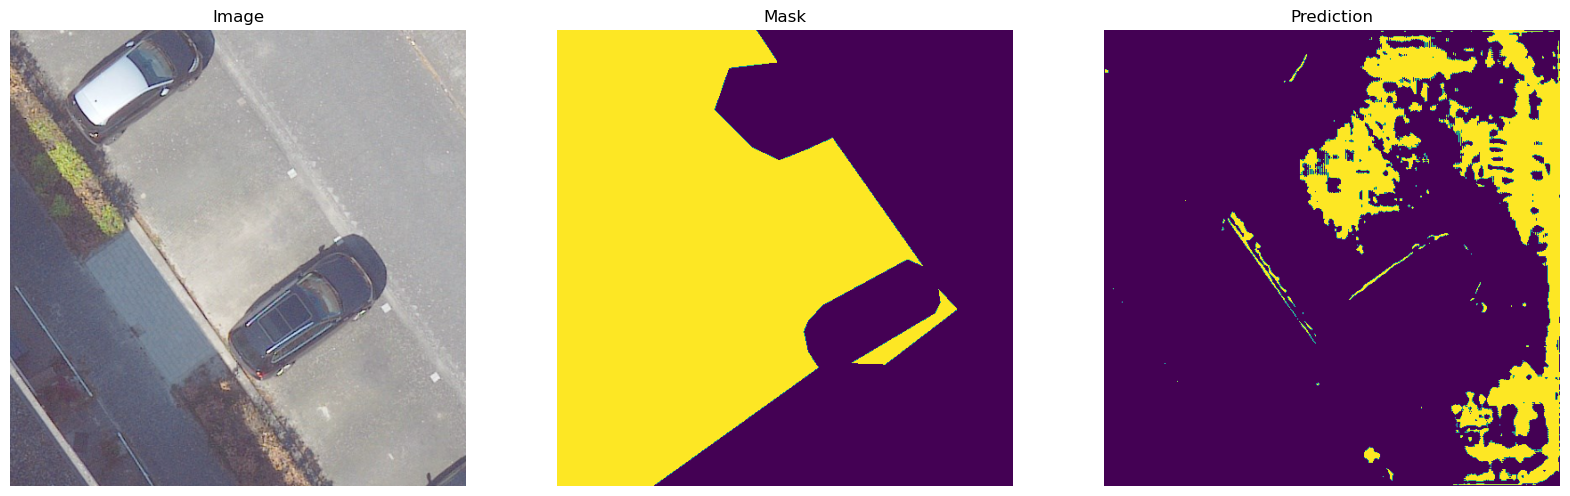

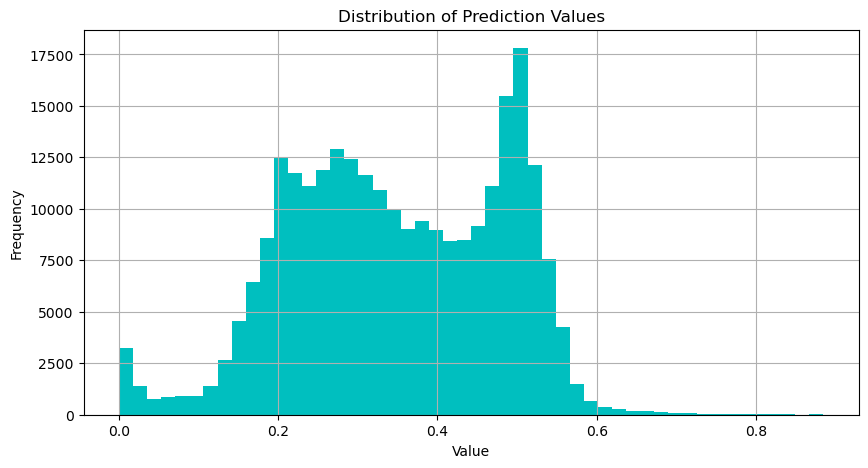

In [ ]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = (output_sigmoid > 0.5).int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set5_4_512_2_8.jpg 0.19427959620952606 0.277008056640625
output tensor([[[[0.1407, 0.1729, 0.2253,  ..., 0.4833, 0.3601, 0.2543],
          [0.1467, 0.1911, 0.2516,  ..., 0.6783, 0.5230, 0.3915],
          [0.2126, 0.2711, 0.3225,  ..., 0.6986, 0.6384, 0.5432],
          ...,
          [0.1737, 0.1892, 0.2113,  ..., 0.4889, 0.4705, 0.5240],
          [0.1584, 0.1675, 0.1891,  ..., 0.4679, 0.4730, 0.4498],
          [0.1403, 0.1761, 0.2031,  ..., 0.4561, 0.3974, 0.3579]]]])
output min tensor(1.6673e-08)
output max tensor(0.8096)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


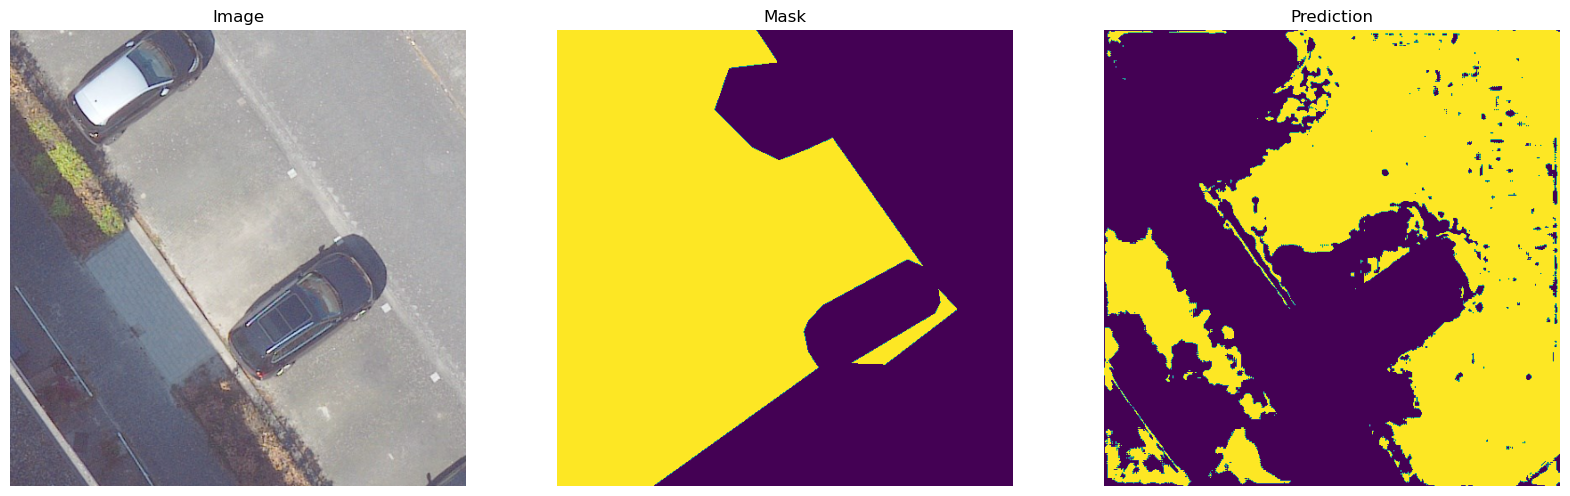

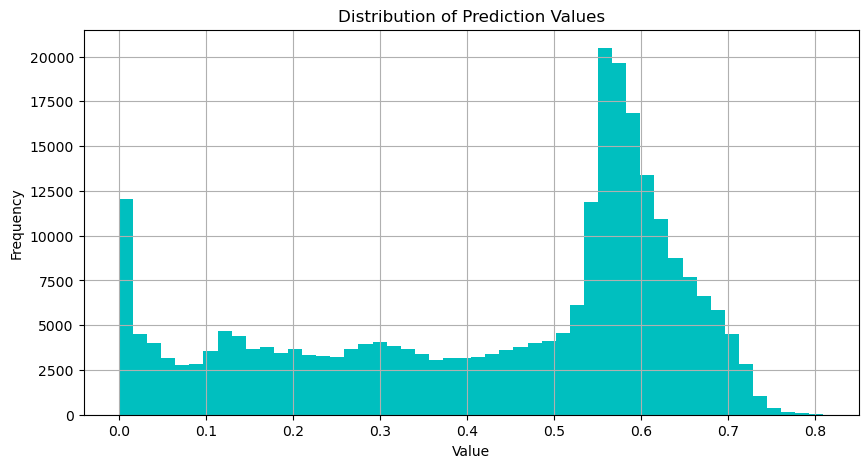

In [ ]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = (output_sigmoid > threshold).int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set6_2_512_14_1.jpg 0.3078036904335022 0.9088096618652344
output tensor([[[[0.0575, 0.0586, 0.0542,  ..., 0.3188, 0.2501, 0.1752],
          [0.0442, 0.0466, 0.0469,  ..., 0.4634, 0.3273, 0.2247],
          [0.0542, 0.0641, 0.0701,  ..., 0.5194, 0.4159, 0.3031],
          ...,
          [0.0990, 0.0700, 0.0741,  ..., 0.0057, 0.0103, 0.0658],
          [0.0968, 0.0666, 0.0716,  ..., 0.0099, 0.0155, 0.0728],
          [0.1037, 0.1154, 0.1279,  ..., 0.0468, 0.0606, 0.1279]]]])
output min tensor(1.9255e-11)
output max tensor(0.7651)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


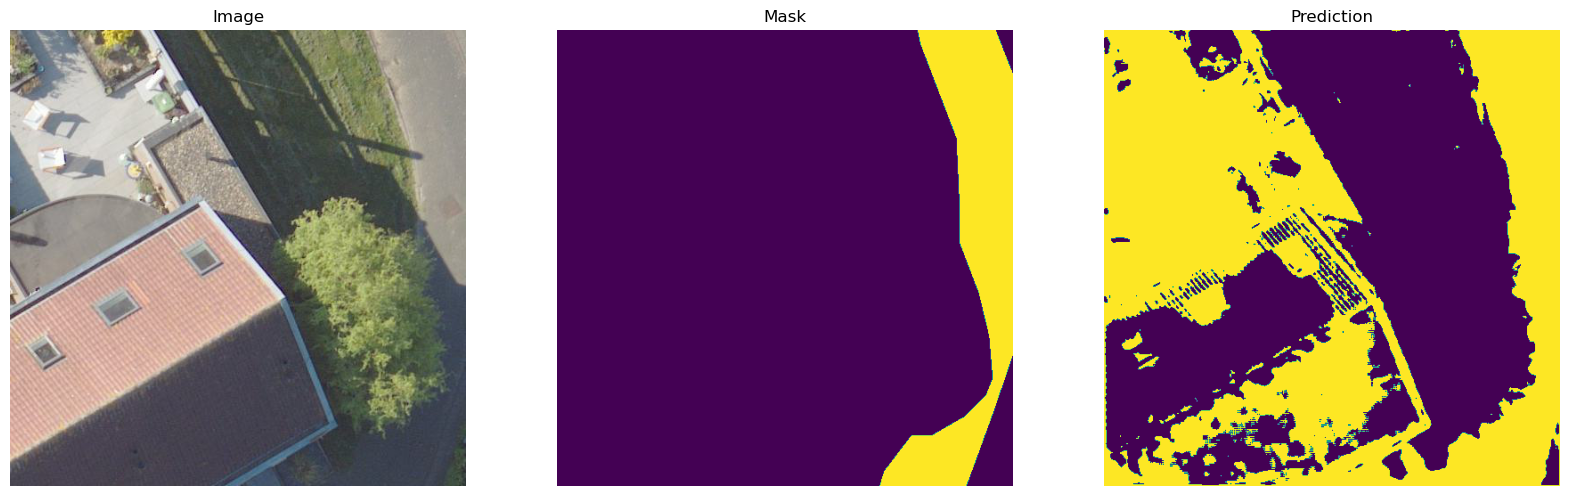

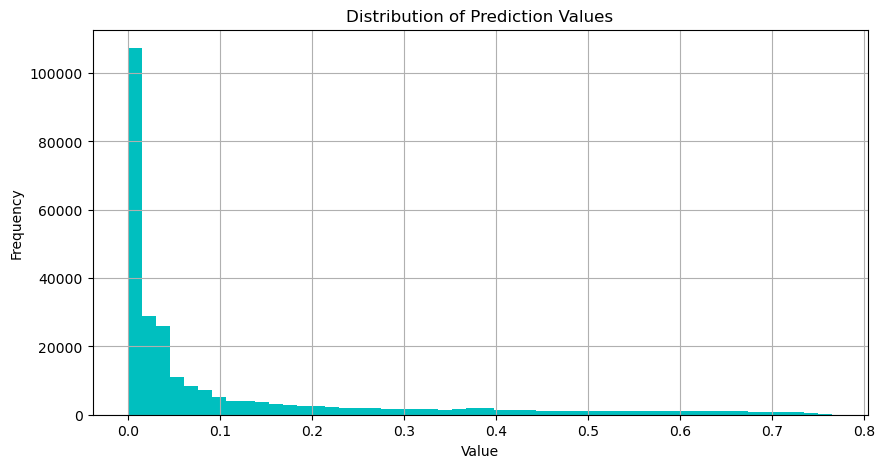

In [ ]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = (output_sigmoid > threshold).int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

c_set6_2_512_14_1.jpg 0.3078036904335022 0.9088096618652344
output tensor([[[[0.0575, 0.0586, 0.0542,  ..., 0.3188, 0.2501, 0.1752],
          [0.0442, 0.0466, 0.0469,  ..., 0.4634, 0.3273, 0.2247],
          [0.0542, 0.0641, 0.0701,  ..., 0.5194, 0.4159, 0.3031],
          ...,
          [0.0990, 0.0700, 0.0741,  ..., 0.0057, 0.0103, 0.0658],
          [0.0968, 0.0666, 0.0716,  ..., 0.0099, 0.0155, 0.0728],
          [0.1037, 0.1154, 0.1279,  ..., 0.0468, 0.0606, 0.1279]]]])
output min tensor(1.9255e-11)
output max tensor(0.7651)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


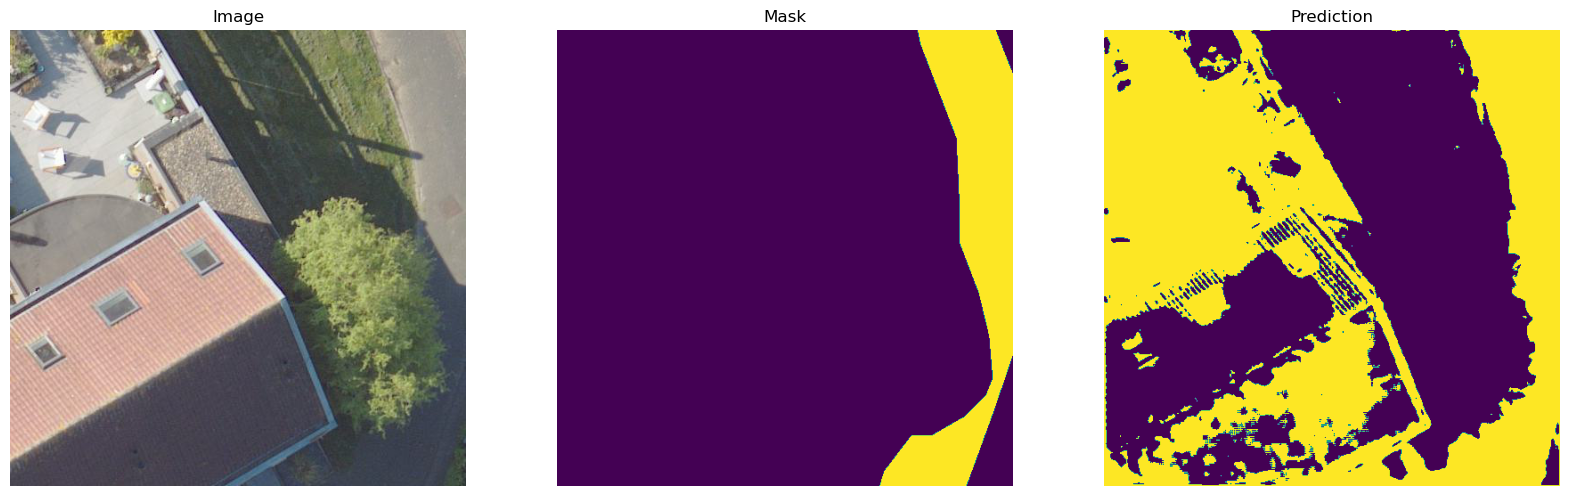

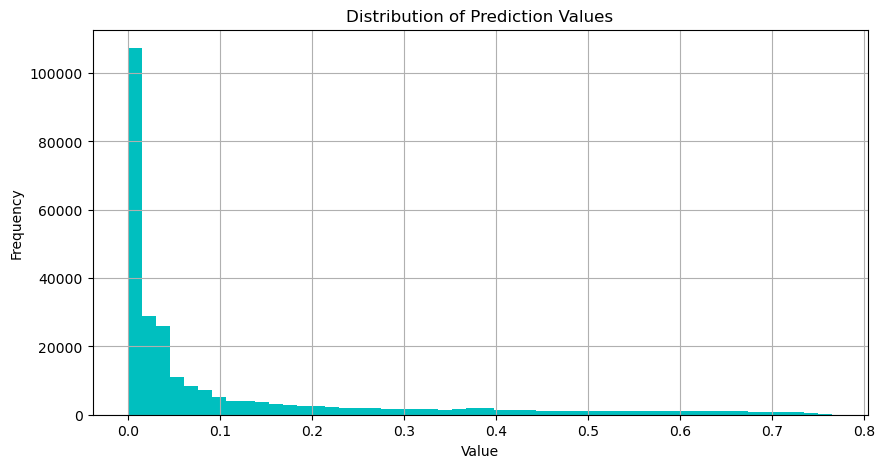

In [ ]:
for item in test_results:
    print(item['image_filename'], item['test_iou'], item['test_accuracy'])

    output_sigmoid = torch.sigmoid(item['output'])

    print('output', output_sigmoid)
    print('output min', output_sigmoid.min())
    print('output max', output_sigmoid.max())

    threshold = output_sigmoid.median() 
    
    # Plot the image, mask, and prediction
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(item['image_np'])
    plt.title('Image')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(item['mask'].squeeze())  # Assuming the mask is stored in 'mask_np'
    plt.title('Mask')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 3)

    print(pred)
    print('---' * 10)

    pred = (output_sigmoid > threshold).int().squeeze(0).squeeze(0).cpu().numpy()

    print(pred)

    plt.imshow(pred)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


        # Convert the prediction to a numpy array and remove extra dimensions
    prediction_np = output_sigmoid.squeeze().cpu().numpy()

    # Display the distribution of the values in the prediction
    plt.figure(figsize=(10, 5))
    plt.hist(prediction_np.flatten(), bins=50, color='c')
    plt.title('Distribution of Prediction Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Function to visualize the activations
def visualize_activation(activation, num_cols=8):
    num_kernels = activation.size(1)
    num_rows = num_kernels // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.show()

# Visualize activations for each layer
for layer, activation in activations.items():
    print(f"Visualizing activations for layer: {layer}")
    visualize_activation(activation)